# Darcy equation in a fractured domain: exercise 2

In this tutorial we present how to solve a Darcy equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unknowns are the velocity $q$ and the pressure $p$.

Let us consider the last test case of the 2d benchmark study reported here [2d problems](https://www.sciencedirect.com/science/article/pii/S0309170817300143).

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.


Let us start by importing the modules for the computation.

In [1]:
import numpy as np
import scipy.sparse as sps

import porepy as pp
import pygeon as pg

We import the fracture network geometry and the mixed-dimensional grid from the module, in particular we are interested to a bidimensional network referenced as `flow_benchmark_2d_case_4`.

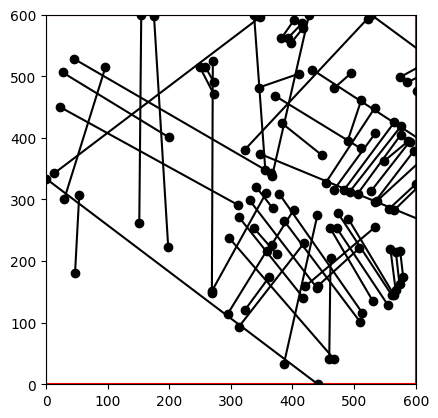

In [2]:
# Define a rectangular domain in terms of range in the two dimensions
bounding_box = {"xmin": 0, "xmax": 600, "ymin": 0, "ymax": 600}
domain = pp.Domain(bounding_box=bounding_box)

# load the coordinates of the fractures
coords = np.loadtxt("benchmark_2d_case_4.csv", delimiter=",")

# collect all the fractures
fractures = [pp.LineFracture(c.reshape(2, 2, order="F")) for c in coords]

# Define a fracture network in 2d
network = pp.create_fracture_network(fractures, domain)

# Show graphically the domain and the fracture
network.plot()

In [3]:
# Set overall target cell size and target cell size close to the fracture.
mesh_args = {"cell_size": 100.0, "cell_size_fracture": 100.0}

# Generate a mixed-dimensional grid
mdg = pp.create_mdg("simplex", mesh_args, network)
pg.convert_from_pp(mdg)
mdg.compute_geometry()

print(mdg)


Mixed-dimensional grid. 
Maximum dimension present: 2 
Minimum dimension present: 0 
Size of highest dimensional grid: Cells: 10710. Nodes: 6700
In lower dimensions: 
62 grids of dimension 1, with in total 1251 cells and 1479 nodes. 
83 grids of dimension 0, with in total 83 cells and 0 nodes. 
Total number of interfaces: 228
62 interfaces between grids of dimension 2 and 1 with in total 2502 cells.
166 interfaces between grids of dimension 1 and 0 with in total 332 cells.



Let us export the grid to ParaView

In [4]:
save = pp.Exporter(mdg, "grid", folder_name="ex3")
save.write_vtu()

We introduce now the data to solve a single-phase flow problem, in particular we assume that the fracture is highly-permeable compared to the surrounding porous media. For doing this, we loop on all the grid and the associated data of the grid bucket, in this case the matrix grid and the fracture grid. Here we proceed as before, by adding the specific properties of the problem.

In [5]:
key = "flow"
bc_val = []
bc_ess = []

# Fracture data
aperture = 1e-2
fracture_perm = 1e-8  # 1e-17
matrix_perm = 1e-14

# declare the discretization objects, useful to setup the data
rt0 = pg.RT0(key)
p0 = pg.PwConstants(key)

scalar_source = []
for sd, data in mdg.subdomains(return_data=True):
    if sd.dim == 1:
        # effective permeability for the fracture
        perm = pp.SecondOrderTensor(aperture * fracture_perm * np.ones(sd.num_cells))
    else:
        # unitary permeability tensor for the rock matrix
        perm = pp.SecondOrderTensor(matrix_perm * np.ones(sd.num_cells))

    parameters = {
        "second_order_tensor": perm,
    }
    pp.initialize_data(sd, data, key, parameters)

    # with the following steps we identify the portions of the boundary
    # to impose the boundary conditions
    left = np.isclose(sd.face_centers[0, :], 0)
    right = np.isclose(sd.face_centers[0, :], 600)
    left_right = np.logical_or(left, right)

    top = np.isclose(sd.face_centers[1, :], 0)
    bottom = np.isclose(sd.face_centers[1, :], 600)
    top_bottom = np.logical_or(top, bottom)

    # compute the pressure boundary condition, which is a natural condition for the RT0 space
    def p_bc(x):
        return 1013250 * (x[0] > 300)

    bc_val.append(-rt0.assemble_nat_bc(sd, p_bc, left_right))
    bc_ess.append(top_bottom)

ess_p_dofs = np.zeros(mdg.num_subdomain_cells(), dtype=bool)
bc_ess.append(ess_p_dofs)

We consider now the interface between the fracture and the porous media, we can set additional data that govern the flow exchange between them, which is the normal permeability.

In [6]:
for mg, d in mdg.interfaces(return_data=True):
    if mg.dim == 1:
        kn = fracture_perm / (aperture / 2)
    else:
        kn = fracture_perm / (aperture**2 / 2)
    pp.initialize_data(mg, d, key, {"normal_diffusivity": kn})

Once the data are assigned to the mixed-dimensional grid, we construct the matrices. In particular, the linear system associated with the equation is given as
$$
\left(
\begin{array}{cc} 
M & -B^\top\\
B & 0
\end{array}
\right)
\left(
\begin{array}{c} 
q\\ 
p
\end{array}
\right)
=\left(
\begin{array}{c} 
0\\ 
f
\end{array}
\right)
$$<br>
$q$ now collects all the flux degrees of freedom for the rock matrix and fracture, similarly $p$ collects all the pressure degrees of freedom for the rock matrix and fracture.

To construct the saddle-point problem, we rely on the `scipy.sparse` function `bmat`. Once the matrix is created, we also construct the right-hand side containing the source term.

In [7]:
# construct the local matrices
mass = pg.face_mass(mdg, keyword=key)
div = pg.cell_mass(mdg) @ pg.div(mdg)

# assemble the saddle point problem
spp = sps.bmat([[mass, -div.T], [div, None]], format="csc")

# get the degrees of freedom for each variable
dof_p, dof_q = div.shape

# assemble the right-hand side
rhs = np.zeros(dof_p + dof_q)
rhs[:dof_q] += np.hstack(bc_val)

We need to solve the linear system, PyGeoN provides a framework for that. Once the problem is solved, we extract the two solutions $q$ and $p$.

In [8]:
# solve the problem
ls = pg.LinearSystem(spp, rhs)
ls.flag_ess_bc(np.hstack(bc_ess), np.zeros(dof_q + dof_p))
x = ls.solve()

# extract the variables
q = x[:dof_q]
p = x[-dof_p:]

Since the computed $q$ is one value per facet of the grid, for visualization purposes we project the flux in each cell center as vector. First, we need to access the corresponding degrees of freedoms for each domain.
We finally export the solution to be visualized by [ParaView](https://www.paraview.org/).

In [9]:
# post process variables
dof_q_loc = np.zeros(2, dtype=int)
dof_p_loc = np.zeros(2, dtype=int)

for sd, data in mdg.subdomains(return_data=True):
    # select the current dofs
    dof_q_loc = dof_q_loc[1] + [0, sd.num_faces]
    dof_p_loc = dof_p_loc[1] + [0, sd.num_cells]

    # extract the local solutions
    q_loc = q[dof_q_loc[0] : dof_q_loc[1]]
    p_loc = p[dof_p_loc[0] : dof_p_loc[1]]

    # compute the solution over each cell
    proj_q = rt0.eval_at_cell_centers(sd)
    cell_q = (proj_q @ q_loc).reshape((3, -1), order="F")
    cell_p = p0.eval_at_cell_centers(sd) @ p_loc

    # save the variables to be exported
    pp.set_solution_values("cell_q", cell_q, data, 0)
    pp.set_solution_values("cell_p", cell_p, data, 0)

save = pp.Exporter(mdg, "sol", folder_name="ex3")
save.write_vtu(["cell_q", "cell_p"])